In [2]:
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt, fabs
from sklearn.decomposition import NMF
from sklearn.utils import shuffle
import scipy.sparse
from numpy.linalg import norm
from time import time
from sys import stdout

functions :

In [3]:
def display_matrix(X, row=None, size=28):
    X_data = np.array([])
    if row is None:
        row = sqrt(len(X))
    for x in X:
        arr = x.reshape(size,size)
        if X_data.any() :
            X_data = np.concatenate( (X_data, arr), axis=1  )
        else:
            X_data = arr
    n = np.array_split(X_data, row, axis=1)
    X_data = np.concatenate(n, axis=0)
    plt.imshow(X_data, interpolation="nearest", cmap=plt.get_cmap('gray'))
    plt.axis("off")
    plt.show()

In [4]:
def relative_error(original,facto):
    return np.sqrt(np.sum(np.square(original - facto))) /  np.sqrt ( np.sum(original) )

In [5]:
def frobenius(original,facto):
    return np.sqrt(np.sum(np.square(original - facto))) 

#### Load data MNIST 

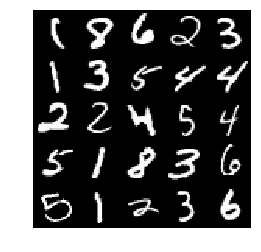

In [6]:
mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]
X_mnist, y_mnist = shuffle(X, y)
display_matrix(X_mnist[0:25])

#### Load face database

In [18]:
faces = np.loadtxt(open("matrice-greyscale-16.csv", "rb"), delimiter = ",")

In [19]:
display_matrix(faces,size=16)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

### NMF with classicial multiplicative update rule

In [18]:
class NMF():
    # some small value
    _EPS = 10**-8

    def __init__(self, data, num_bases=4):

        # set variables
        self.data = data
        self._num_bases = num_bases

        # initialize H and W to random values
        (self._data_dimension, self._num_samples) = self.data.shape


    def frobenius_norm(self):
        # check if W and H exist
        if hasattr(self,'H') and hasattr(self,'W') and not scipy.sparse.issparse(self.data):
            err = np.sqrt( np.sum((self.data[:,:] - np.dot(self.W, self.H))**2 ))
        else:
            err = -123456

        return err

    def init_w(self):
        self.W = np.random.random((self._data_dimension, self._num_bases))

    def init_h(self):
        self.H = np.random.random((self._num_bases, self._num_samples))

    def update_h(self):
            # pre init H1, and H2 (necessary for storing matrices on disk)
            H2 = np.dot(np.dot(self.W.T, self.W), self.H) + 10**-9
            self.H *= np.dot(self.W.T, self.data[:,:])
            self.H /= H2

    def update_w(self):
            # pre init W1, and W2 (necessary for storing matrices on disk)
            W2 = np.dot(np.dot(self.W, self.H), self.H.T) + 10**-9
            self.W *= np.dot(self.data[:,:], self.H.T)
            self.W /= W2

    def converged(self, i):
        derr = np.abs(self.ferr[i] - self.ferr[i-1])/self._num_samples
        if derr < self._EPS:
            return True
        else:
            return False

    def factorize(self, niter=1, show_progress=False,
                  compute_w=True, compute_h=True, compute_err=True):
 
        # create W and H if they don't already exist
        # -> any custom initialization to W,H should be done before
        if not hasattr(self,'W'):
               self.init_w()

        if not hasattr(self,'H'):
                self.init_h()

        if compute_err:
            self.ferr = np.zeros(niter)

        for i in range(niter):
            if compute_w:
                self.update_w()

            if compute_h:
                self.update_h()

            if compute_err:
                self.ferr[i] = self.frobenius_norm()
                #print('Iteration ' + str(i+1) + '/' + str(niter) +
                #' FN:' + str(self.ferr[i]))
            #else:
                #print('Iteration ' + str(i+1) + '/' + str(niter))


            # check if the err is not changing anymore
            if i > 1 and compute_err:
                if self.converged(i):
                    # adjust the error measure
                    self.ferr = self.ferr[:i]
                    break

#### comparaison

In [19]:
it = []
err = []
i = 10
for x in range(0,49):
    nmf_mdl = NMF(faces, num_bases=5)
    nmf_mdl.factorize(i)
    re = nmf_mdl.W.dot(nmf_mdl.H)
    
    it.append(i)
    err.append( frobenius(faces,re) )
    i = i + 20

NameError: name 'faces' is not defined

In [20]:
it2 = []
err2 = []
i2 = 10
for x2 in range(0,49):
    nmf_mdl2 = NMF(faces, num_bases=8)
    nmf_mdl2.factorize(i2)
    re2 = nmf_mdl2.W.dot(nmf_mdl2.H)
    
    it2.append(i2)
    err2.append( frobenius(faces,re2) )
    i2 = i2 + 20

NameError: name 'faces' is not defined

In [21]:
it3 = []
err3 = []
i3 = 10
for x3 in range(0,39):
    nmf_mdl3 = NMF(faces, num_bases=12)
    nmf_mdl3.factorize(i3)
    re3 = nmf_mdl3.W.dot(nmf_mdl3.H)
    
    it3.append(i3)
    err3.append( frobenius(faces,re3) )
    i3 = i3 + 20

NameError: name 'faces' is not defined

In [22]:
display_matrix(re3,size=128)

NameError: name 're3' is not defined

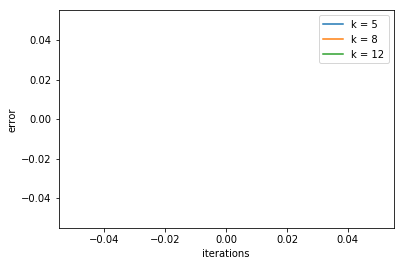

In [23]:
plt.plot(it, err, label='k = 5')
plt.plot(it2, err2, label='k = 8')
plt.plot(it3, err3, label='k = 12')
plt.legend(loc='upper right')
plt.xlabel('iterations')
plt.ylabel('error')
plt.figure(figsize=(50,50))
plt.show()

## NMF alternative non-negative least squares using projected gradients

In [27]:
def nmf(V,Winit,Hinit,tol,maxiter,timelimit=60000):

 W = Winit; H = Hinit; initt = time();

 gradW = np.dot(W, np.dot(H, np.transpose(H))) - np.dot(V, np.transpose(H))
 gradH = np.dot(np.dot(np.transpose(W), W), H) - np.dot(np.transpose(W), V)
 initgrad = norm(np.r_[gradW, np.transpose(gradH)])
 #print('Init gradient norm '+ initgrad)
 tolW = max(0.001,tol)*initgrad
 tolH = tolW

 for iter in range(1,maxiter):
  # stopping condition
  projnorm = norm(np.r_[gradW[np.logical_or(gradW<0, W>0)],
                                 gradH[np.logical_or(gradH<0, H>0)]])
  #if projnorm < tol*initgrad or time() - initt > timelimit: break
  if projnorm < tol*initgrad : break
  
  (W, gradW, iterW) = nlssubprob(np.transpose(V),np.transpose(H),np.transpose(W),tolW,1000)
  W = np.transpose(W)
  gradW = np.transpose(gradW)
  
  if iterW==1: tolW = 0.1 * tolW

  (H,gradH,iterH) = nlssubprob(V,W,H,tolH,1000)
  if iterH==1: tolH = 0.1 * tolH

  #if iter % 10 == 0: stdout.write('.')

 #print('\nIter = '+str(iter)+' Final proj-grad norm '+str(projnorm))
 return (W,H)

def nlssubprob(V,W,Hinit,tol,maxiter):
 
 H = Hinit
 WtV = np.dot(W.T, V)
 WtW = np.dot(W.T, W) 

 alpha = 1; beta = 0.1;
 for iter in range(1, maxiter):  
  grad = np.subtract(np.dot(WtW, H),WtV)
  projgrad = norm(grad[np.logical_or(grad < 0, H >0)])
  if projgrad < tol: break

  # search step size 
  for inner_iter in range(1,20):
   Hn = H - alpha*grad
   Hn = np.where(Hn > 0, Hn, 0)
   d = Hn-H
   gradd = np.sum(grad * d)
   dQd = np.sum(np.dot(WtW,d) * d)
   suff_decr = 0.99*gradd + 0.5*dQd < 0;
   if inner_iter == 1:
    decr_alpha = not suff_decr; Hp = H;
   if decr_alpha: 
    if suff_decr:
     H = Hn; break;
    else:
     alpha = alpha * beta;
   else:
      if not suff_decr or (Hp == Hn).all():
       H = Hp; break;
      else:
       alpha = alpha/beta; Hp = Hn;

  if iter == maxiter:
   print("Max iter in nlssubprob")
 return (H, grad, iter)

In [28]:
v = X_mnist[0:25]
_num_bases = 4
(_data_dimension, _num_samples) = v.shape
W = np.random.random((_data_dimension, _num_bases))
H = np.random.random((_num_bases, _num_samples))

(wo,ho) = nmf(v, W, H, 0.0001, 600)

In [29]:
display_matrix( wo.dot(ho) , size=128)

ValueError: cannot reshape array of size 784 into shape (128,128)

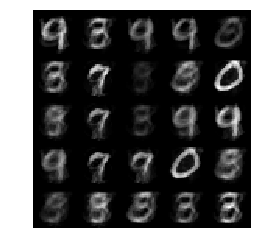

In [30]:
display_matrix(wo.dot(ho))

In [31]:
it=[ [], [], [] ]
err=[ [], [], [] ]
d = 0
v = faces
for x in (5, 8, 12):
    i = 50 
    for y in range(0,10):
        it[d].append(i)
        _num_bases = x
        (_data_dimension, _num_samples) = v.shape
        W = np.random.random((_data_dimension, _num_bases))
        H = np.random.random((_num_bases, _num_samples))

        (wo,ho) = nmf(v, W, H, 0.0001, i)
        err[d].append( frobenius(v,wo.dot(ho)) )
        i = i + 50
    d = d +1

NameError: name 'faces' is not defined

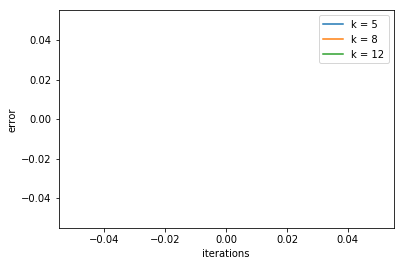

In [32]:
plt.plot(it[0], err[0], label='k = 5')
plt.plot(it[1], err[1], label='k = 8')
plt.plot(it[2], err[2], label='k = 12')
plt.legend(loc='upper right')
plt.xlabel('iterations')
plt.ylabel('error')
plt.figure(figsize=(50,50))
plt.show()

In [33]:
si = np.copy(it)
serr = np.copy(err)

# NMF WITH SVD INITIALISATION

In [34]:
from sklearn.decomposition import NMF

In [35]:
model = NMF(n_components=2, init='nndsvda')
W = model.fit_transform(X)
H = model.components_

In [36]:
it=[ [], [], [] ]
err=[ [], [], [] ]
d = 0
for x in (5, 8, 12):
    i = 50 
    for y in range(0,10):
        model = NMF(n_components=2, init='nndsvda', max_iter=i)
        W = model.fit_transform(X)
        H = model.components_
        i = i + 50
    d = d +1

In [ ]:
BMF / Nimfa / NMF / ArtIMage sur GIthub / SPherical K means Centroide / ICA / PCA / CA / TriFactorisation
Noir et BLanc / binarisation / couleur algébre combinaison linéaire / NMI / R to Python importation / SParsité NMF / 